# Text Analytics Group Assignment #1
#### Group Memebrs: He Wang, Junhong Xu, Rui Ying, Kelly Zhang



In [0]:
!pip install selenium
!apt install -yq chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin

import sys
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')
from selenium import webdriver
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')

In [0]:
import pandas as pd
driver = webdriver.Chrome('chromedriver', options=chrome_options)

## 1. Script Data From Website

In [0]:

user=[]
date_tot=[]
comment_tot=[]
time_tot=[]
for j in range(1,100):
    driver.get('https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans/p%s'% j)
    for i in range(1,50):
        userid_element = driver.find_elements_by_xpath('/html/body/div[1]/main/div/div[3]/div[5]/div[1]/ul/li[%s]/div/div[2]/div[1]/span[1]/a[2]'% i )[0]
        userid = userid_element.text
        user.append(userid)

        user_date = driver.find_elements_by_xpath('/html/body/div[1]/main/div/div[3]/div[5]/div[1]/ul/li[%s]/div/div[2]/div[2]/span/a/time'% i)[0]
        date = user_date.get_attribute('title')
        date_tot.append(date)

        user_message = driver.find_elements_by_xpath('/html/body/div[1]/main/div/div[3]/div[5]/div[1]/ul/li[%s]/div/div[3]/div/div[1]'% i)[0]
        comment = user_message.text
        comment_tot.append(comment)

        time_element = driver.find_elements_by_xpath('/html/body/div[1]/main/div/div[3]/div[5]/div[1]/ul/li[%s]/div/div[2]/div[2]/span/a/time'% i)[0]
        time = time_element.text
        time_tot.append(time)

In [0]:
df=pd.DataFrame(list(zip(user,time_tot,date_tot,comment_tot)),columns=['username', 'time','date', 'comment'])

In [0]:
df.to_csv("results12.csv", header=True,sep=",",index=False, encoding='utf-8')

## 2. Data Preprocessing
### 1). find and replace
### 2). filter words
### 3). word counts

In [1]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
import pandas as pd
import csv
import re
import numpy as np

[nltk_data] Downloading package stopwords to C:\Users\Rui
[nltk_data]     Ying\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
import csv
comment_list = []
with open('results12.csv',encoding="utf8") as f:
    rows = csv.reader(f, delimiter = ',')
    for row in rows:
        comment_list.append(row[3])
comment_list = comment_list[1:]

In [9]:
find_replace_list = {}
with open('models (5).csv') as f:
    rows = csv.reader(f, delimiter = ',')
    for row in rows:
        find_replace_list[row[1]] = row[0]

In [10]:
def find_replace(comment):
    replaced = ""
    comment= re.findall(r'\w+',comment)
    for word in comment:
        if word in find_replace_list:
            replaced += find_replace_list[word]
            replaced += " "
        else:
            replaced += word
            replaced += " "
    return replaced

In [11]:
comment_list_1 = comment_list.copy()
for i in range(len(comment_list_1)):
    comment_list_1[i] = find_replace(comment_list_1[i])
df_replaced = pd.DataFrame(columns = ['comment'], data = comment_list_1)
df_replaced.to_csv("result_after_find_replace.csv", sep=",")

In [15]:
def filter_word(comment):
    stop_words = set(stopwords.words('english'))
    word = re.findall(r'\w+',comment)
    filtered_sentence = ''
    for w in word: 
        if w.lower() not in stop_words: 
            filtered_sentence +=' '
            filtered_sentence += w    
    return filtered_sentence  

In [12]:
def word_count(comment): 
    word_dict = {}
    word = re.findall(r'\w+',comment)
    for j in word:
        if j not in word_dict:
            word_dict[j] = 1
    return word_dict

In [16]:
outer_dict = {}
for i in comment_list_1:
    inner_dict = {}
    i = i.lower() 
    filter_comment = filter_word(i)
    replaced_comment = find_replace(filter_comment)
    inner_dict = word_count(replaced_comment)
    for key, value in inner_dict.items():
        if key not in outer_dict:
            outer_dict[key] = 1
        else:
            outer_dict[key] += 1

In [17]:
word_freq = pd.DataFrame(data = outer_dict,index=[0])
word_freq = word_freq.T
word_freq.to_csv("word_freq.csv", sep=",")

## 3. Calculate Lift 
### 1). Find Top 10 brands
### 2). Calcualte Lift
### 3). MDS 

In [18]:
comment_list = []
with open('result_after_find_replace.csv') as f:
    rows = csv.reader(f, delimiter = ',')
    for row in rows:
        comment_list.append(row[1])
comment_list = comment_list[1:]
# import word frequency file from preprocessing 

word_freq = {}
with open('word_freq.csv') as g:
    rows = csv.reader(g, delimiter = ',')
    for row in rows:
        word_freq[row[0]] = int(row[1])

In [28]:
import numpy as np
brand_list =[]
with open('models (5).csv') as f:
    rows = csv.reader(f, delimiter = ',')
    for row in rows:
        brand_list.append(row[0])
brand_list = np.unique(brand_list)
brand_list = list(brand_list)
brand_list.append('lexus')

# finding the brand by filtering out just brands word frequenct
top10 = word_freq.copy()
for key in word_freq:
    if key not in brand_list:
        del top10[key] 
    else:
        pass

top = sorted(top10.items(), key=lambda x:x[1], reverse=True)
top10_brand=[]
top10_table =[]
for x in top:
    if x[0]!='car'and x[0]!='sedan'and  x[0]!='problem' and x[0]!='seat' and len(top10_brand)<10:
        top10_brand.append(x[0])
        top10_table.append(x)
    else:
        pass

top_10_df = pd.DataFrame(data = top10_table)
top_10_df.columns = ["Brand","Frequency"]

In [31]:
def single_word_count(word, comment_list):
    count = 0
    for comment in comment_list:
        comment = comment.lower()
        comment_list = re.findall(r'\w+',comment)
        if word in comment_list:
            count += 1
    return count

def pair_word_count(word1,word2, comment_list):
    count = 0
    for comment in comment_list:
        comment = comment.lower()
        comment_list = re.findall(r'\w+',comment)
        if word1 in comment_list and word2 in comment_list:
            count += 1
    return count

def lift(Wcount_A, Wcount_B, N, WcountAB):
    return N * float(WcountAB) /(Wcount_A*Wcount_B)

top10=top10_brand
top_lift=np.zeros((10,10))
for x in range(len(top10)):
    for y in range(len(top10)):
        a = single_word_count(top10[x],comment_list)
        b = single_word_count(top10[y],comment_list)
        c = pair_word_count(top10[x],top10[y], comment_list)
        if x == y:
            top_lift[x][y] = 1
        else:
            top_lift[x][y] = (lift(a,b,len(comment_list),c))

top_table = pd.DataFrame(top_lift)
top_table.columns =top10
top_table.index = top10

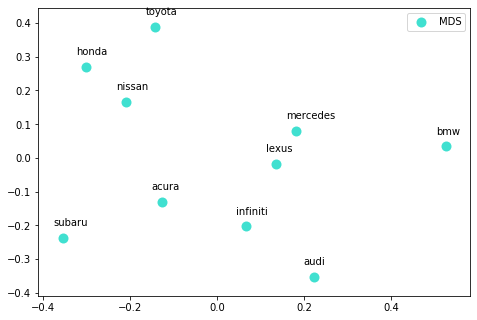

In [42]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
from sklearn import manifold
from sklearn.metrics import euclidean_distances
from sklearn.decomposition import PCA
from matplotlib.font_manager import FontProperties

seed = 6
mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9, random_state=seed,
                   dissimilarity="precomputed", n_jobs=1)
pos = mds.fit(1/top_lift).embedding_
plt.axes([0., 0., 1., 1.])

s = 100
plt.scatter(pos[:, 0], pos[:, 1], color='turquoise', s=s, lw=0, label='MDS')
plt.legend(scatterpoints=1, loc='best', shadow=False)

font0 = FontProperties()
font = font0.copy()
for label, x, y in zip(top10, pos[:, 0], pos[:, 1]):
    plt.annotate(label,xy = (x, y), xytext = (-10, 10),
    fontproperties=font,textcoords = 'offset points', ha = 'left', va = 'bottom')


## 4. Lift :(Attribute, Lift)

In [47]:
#check to see if we should replace some attributes 
def checklift(word1,word2,comment):
    a = single_word_count(word1,comment_list)
    b = single_word_count(word2,comment_list)
    c = pair_word_count(word1,word2, comment_list) 
    return lift(a,b,len(comment),c)
top5 = top10[:5]
rel = ['reliability',"safe"]
for y in top5:
    for x in rel:
        print(y,x, 'lift:',checklift(y,x,comment_list))
print()
price = ['msrp']

for e in top5:
    for b in price:
        print(e,b,'lift:',checklift(e,b,comment_list))
print()

inte = ["interior","seat", "leather"]
for f in top5:
    for c in inte:
        print(f,c,'lift:',checklift(f,c,comment_list))
print()

per = ["performance","engine", "power", "speed",'fwd','rwd','manual','sport']
for g in top5:
    for d in per:
        print(g,d,'lift:',checklift(g,d,comment_list))
print()

per = ['luxury','luxurious']
for g in top5:
    for d in per:
        print(g,d,'lift:',checklift(g,d,comment_list))
print()

bmw reliability lift: 1.7060027978148908
bmw safe lift: 1.6259317852737705
acura reliability lift: 1.3830856409708114
acura safe lift: 1.4829420396184887
honda reliability lift: 1.609035275386835
honda safe lift: 4.1404916353704335
audi reliability lift: 2.1172411352537335
audi safe lift: 1.963331714424478
infiniti reliability lift: 2.0668680058647353
infiniti safe lift: 0.6257201823028635

bmw msrp lift: 1.2055362267720575
acura msrp lift: 1.5960737003728889
honda msrp lift: 0.8252526283556191
audi msrp lift: 1.5261361986351096
infiniti msrp lift: 2.1201377998303212

bmw interior lift: 1.2722675697313812
bmw seat lift: 1.6646381775709762
bmw leather lift: 1.4669517884914463
acura interior lift: 1.6031568676822359
acura seat lift: 1.3580627099664053
acura leather lift: 1.7520685579196218
honda interior lift: 1.3736305583221045
honda seat lift: 1.3611656712229927
honda leather lift: 1.3341584158415842
audi interior lift: 2.0887990665888823
audi seat lift: 2.1207162000342135
audi leather

In [48]:
import csv
attribute_list = {}
with open('attribute.csv') as f:
    rows = csv.reader(f, delimiter = ',')
    for row in rows:
        attribute_list[row[1]] = row[0]

In [49]:
def find_replace_1(comment ,replace_list):
    replaced = ""
    comment= re.findall(r'\w+',comment)
    for word in comment:
        if word in replace_list:
            replaced += replace_list[word]
            replaced += " "
        else:
            replaced += word.lower()
            replaced += " "
    return replaced

In [50]:
find_replace_attribute = comment_list.copy()
for i in range(len(find_replace_attribute)):
    find_replace_attribute[i] = find_replace_1(find_replace_attribute[i], attribute_list)

In [51]:
attribute_lift = np.zeros((10,5))
att = ['performance','interior','luxury','price','reliability']
for i in range(len(top10)):
    for j in range(len(att)) :
        a = single_word_count(top10[i],find_replace_attribute)
        b = single_word_count(att[j],find_replace_attribute)
        c = pair_word_count(top10[i],att[j], find_replace_attribute)
        attribute_lift[i][j] = lift(a,b,len(find_replace_attribute),c)
        
attribute_lift_table= pd.DataFrame(attribute_lift)
attribute_lift_table.columns =att
attribute_lift_table.index = top10

In [59]:
attribute_lift = np.zeros((5,5))
att = ['performance','interior','luxury','price','reliability']
for i in range(len(top5)):
    for j in range(len(att)) :
        a = single_word_count(top10[i],find_replace_attribute)
        b = single_word_count(att[j],find_replace_attribute)
        c = pair_word_count(top10[i],att[j], find_replace_attribute)
        attribute_lift[i][j] = lift(a,b,len(find_replace_attribute),c)
        
attribute_lift_table= pd.DataFrame(attribute_lift)
attribute_lift_table.columns =att
attribute_lift_table.index = top5

In [53]:
aspiration_list = {}
with open('aspiration.csv') as f:
    rows = csv.reader(f, delimiter = ',')
    for row in rows:
        aspiration_list[row[1]] = row[0]

In [66]:
find_replace_aspiration = find_replace_attribute.copy()
for i in range(len(find_replace_aspiration)):
    find_replace_aspiration[i] = find_replace_1(find_replace_aspiration[i],aspiration_list)

In [67]:
asp_ass = {}
for i in top10:
    a = single_word_count("aspiration",find_replace_aspiration)
    b = single_word_count(i,find_replace_aspiration)
    c = pair_word_count("aspiration",i, find_replace_aspiration) 
    asp_ass[i] = lift(a,b,len(find_replace_aspiration),c) 
asp_table = pd.DataFrame(asp_ass, index = ["Aspiration"])

In [69]:
df_final = pd.DataFrame(columns = ['comment'], data = find_replace_aspiration)
df_final.to_csv("final_data.csv", sep=",")

# Analysis

URL: https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans


# Task A 

### Top 10 brands by frequency

In [62]:
top_10_df

,Brand,Frequency
0,bmw,1319
1,acura,568
2,honda,442
3,audi,428
4,infiniti,401
5,lexus,345
6,toyota,320
7,nissan,310
8,subaru,204
9,mercedes,177


### Lift ratios for associations between the brands

In [63]:
top_table

,bmw,acura,honda,audi,infiniti,lexus,toyota,nissan,subaru,mercedes
bmw,1.000000,1.591799,1.232488,1.832952,2.031888,2.164893,1.371695,1.360154,1.249060,1.991514
acura,1.591799,1.000000,2.952180,2.220932,3.024314,3.116327,1.601064,2.398374,2.278428,2.457447
honda,1.232488,2.952180,1.000000,1.277786,1.596998,1.577787,5.198020,5.387947,1.908465,2.088248
audi,1.832952,2.220932,1.277786,1.000000,2.555758,2.739559,1.183099,1.587656,1.960731,3.465707
infiniti,2.031888,3.024314,1.596998,2.555758,1.000000,3.927225,1.256858,3.838553,2.082971,3.080668
lexus,2.164893,3.116327,1.577787,2.739559,3.927225,1.000000,3.104348,2.028010,1.955485,4.716068
toyota,1.371695,1.601064,5.198020,1.183099,1.256858,3.104348,1.000000,4.947115,1.807947,2.217391
nissan,1.360154,2.398374,5.387947,1.587656,3.838553,2.028010,4.947115,1.000000,2.162315,2.028010
subaru,1.249060,2.278428,1.908465,1.960731,2.082971,1.955485,1.807947,2.162315,1.000000,1.596314
mercedes,1.991514,2.457447,2.088248,3.465707,3.080668,4.716068,2.217391,2.028010,1.596314,1.000000


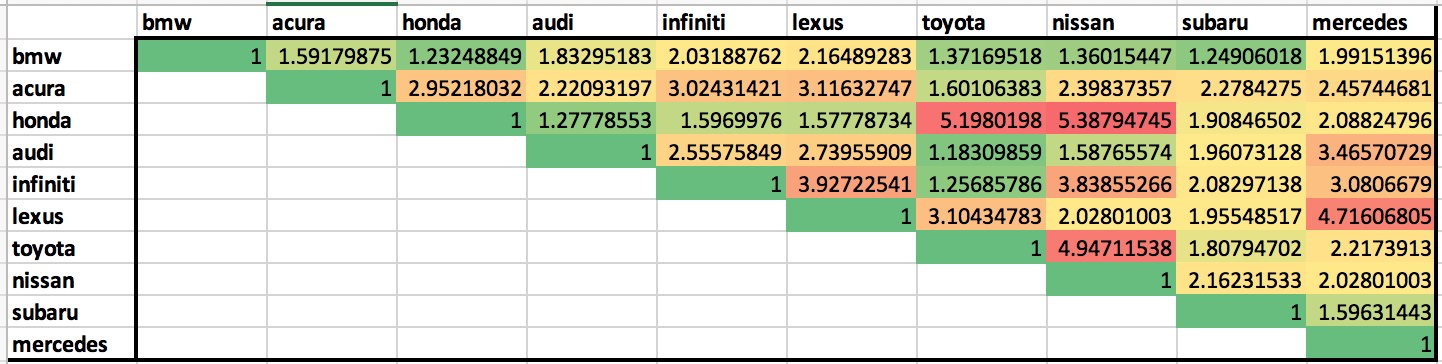

In [3]:
from IPython.display import Image
Image("brand_lift.png") 

#### Lift:
(>4): (honda, toyota), (honda, nissan), (toyota, nissan), (lexus, mercedes)

(3-4): (Infiniti, lexus), (Infiniti, nissan), (Infiniti, acura) (audi, mercedes), (lexus, acura), (lexus, toyota)

### MDS

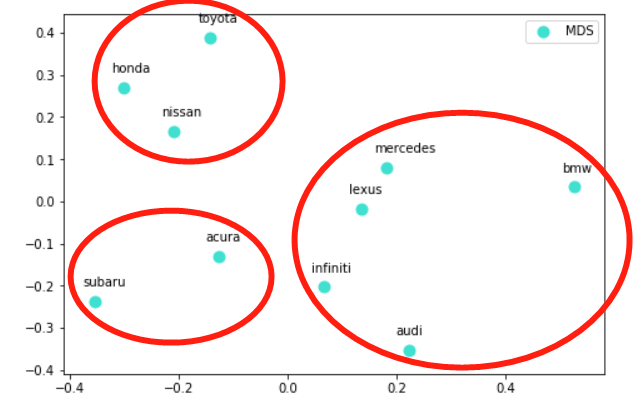

In [1]:
from IPython.display import Image
Image("MDS.png") 

Based on the distance between Top 10 Brands, brands can be divided into three groups. 

1st group: mercedes, lexus, audi, infiniti and bmw; 

2nd group: honda, nissan, toyota; 

3rd group: subaru, aura.


## Task B 

BMW: BMW belongs to the luxury group in the customers’ view. Also BMW is at a blank space, suggesting that when people talked about BMW, there are low frequency to mention other brands,  which means that there is no brand for BMW customers to switch to.  It is a double-edged sword. On the positive side, BMW establishes a special impression on customers and it is easier to manage customer retention since there is a low possibility for customers with a BMW to switch BMW to other brands. On the negative side, it is also difficult for BMW to attract more customers because when people discuss other brands, they hardly consider to buy a BMW. Actually, it is a common trade-off for a mature brand, whether to diversify products to increase its market share or focus on the most representative product. 
 
 
Acura: From the above graph we can see that Acura is in the same group with Subaru. As the premium brand of Honda, Acura is the most distant brand from other traditional luxury brands such as Audi and Mercedes. It seems like consumers in our dataset aren’t considering Acura as a luxury brand. For this reason, brand managers at Acura should really try to better promote their brand so that it fits into the same group as Lexus and Infiniti, and thus better justify the premium pricing associated with the Acura brand. However, an advantage of being a distant brand is that consumers will not likely to switch to a different brand as opposed to Lexus and Infiniti. This indicates that Acura has loyal customers and perhaps the brand offers something that other luxury brands don’t offer. 
 


## Task C 

First, we did word-replace work. There are basically two conditions for replacing :1) Two words have similar meanings. 2) If two words have similar meanings, both two words have high lift with brand, then replace it. Because if one word has low lift with brands and one word has high lift, the lift will decrease if replacing. 
The 5 most frequently mentioned attributes are performance, interior, price, luxury and reliability. A bunch of similar words in each attribute are listed as below.


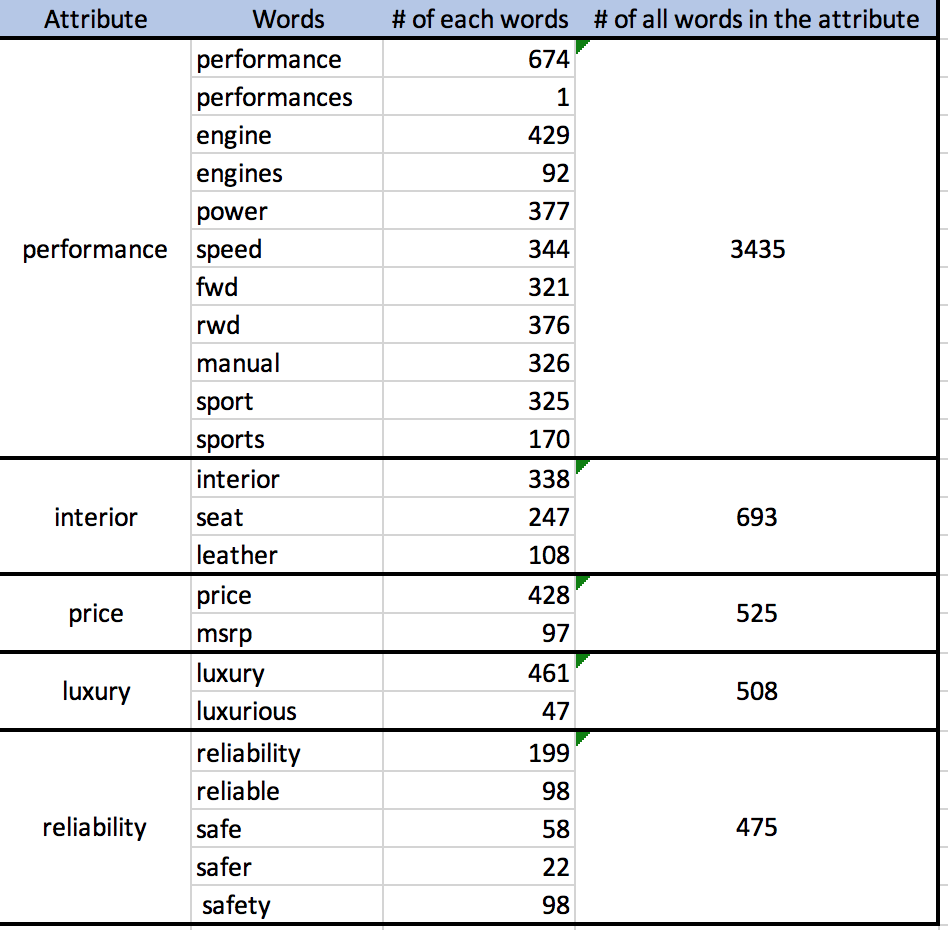

In [2]:
from IPython.display import Image
Image("Attribute_frequency.png") ## add later

### Lift Ratio between brands and attributes

In [65]:
attribute_lift_table

,performance,interior,luxury,price,reliability
bmw,1.323717,1.395997,1.427304,1.524367,1.501166
acura,1.346382,1.388361,2.092151,1.610245,1.360372
honda,1.340278,1.292138,1.863939,1.717957,2.042079
audi,1.410357,1.972607,1.704547,2.183870,1.830106
infiniti,1.338745,1.738385,1.760516,1.712397,1.388716


Based on the lift table for (attribute, brand), for each attribute, the most strongly associated brand is as below:

Performance: audi

Interior: audi

Luxury:acura

Price: audi

Reliability: honda

## Task D Answer

We assume all sentiment associated with the attributes mentioned are positive. The basic idea is that we found the top 5 most frequent attributes that customers are concerned about. Hence, if a brand aims to improve their market share, it is reasonable to focus on these 5 attributes to design products and also conduct relevant marketing or advertising strategies. 

BMW:
Among the top 5 most mentioned attributes, bmw was not a lead in any of them. It hangs around in the middle for Performance, Interior, and Reliability. Price wise, bmw’s score is on the bottom. Surprisingly bmw scored lowest in terms of luxury compared to other brands, our assumption is that bmw’s impression of luxury is deeply buried inside of people’s heads that they don’t even have to mention it. In terms of all other lift values, our advice for bmw’s marketing team is to keep enforcing on what they are doing for the luxury. However, more emphasis is needed by the product manager to improve the performance of the vehicle. 

Infiniti:
Comparing with other brands’ lift vale, Infiniti is looking average on every attribute.  It’s good that none of the attribute is at the bottom, but that means none of their characteristics stands out. Our advice to Infiniti’s marketing and development team is not to try to market everything, instead focus on one or two features first. This way it can help the brand to establish a more memorable impression to consumers.

Audi:
Of the top 5 most frequent attributes, three of them have the highest lift with Audi. When people discuss performance, interior and price, the most related brand is Audi. Since we assume all sentiment associated with the mentions are positive, it is great that the general impression that Audi leaves on customers’ heart is the car with great performance, nice interior and high price. In that case, we would recommend the product manager to pay attention to the attributes associated with reliability , such as the safety of the car. As for marketing manager, he/she should focus on the traditional attributes that consumers associate Audi cars with, and continue to promote brand value through value-based advertising.  

Honda:
When customers talk about reliability, the most frequently mentioned brand is Honda. If this aligns with the positioning of Honda in the marketplace, the advantage of reliability can be integrated into the marketing strategies. However, if honda wants to target  customers, for example, who value the performance most, the product manager should focus on how to improve the performance of Honda car. 
 
Acura:
When customers talk about luxury, the most frequently mentioned brand is Acura. Based on the analysis in task B, it seems that when people talk about luxury sedan, there is a high probability of mentioning Acura. As the premium brand of Honda, Acura should find its own position, whether to improve performance and interior, like audi or to enhance reliability, like honda. Since acura aims to compete with luxury brands like Audi, Mercedes or BMW, the product manager at Acura should consider at least one attribute which can be competitive with other brands so that Acura can increase their market share in the luxury sedan market. 
 


## Task E Answer

### Brand Association with Aspiration

In [68]:
asp_table

,bmw,acura,honda,audi,infiniti,lexus,toyota,nissan,subaru,mercedes
Aspiration,1.320875,1.41001,1.522253,1.403814,1.364412,1.419917,1.266885,1.284628,1.537827,1.284248


We replaced words such as wish, dream, desire, like , love, enjoy, exciting, amazing, confidence with aspiration. After replacing the words with aspiration, we run the lift ratio calculation. The most aspirational brand in our data is Subaru. Aspiration is associated with ambition and go-getting. We think that the Subaru brand is attractive to a particular group of people who are ambitious and have a desire to be successful. Or it could be the other way around, that the brand itself represents aspiration and success. Thus, consumers want to own a Subaru as a symbol of social status. In terms of business implications, we know that the brand itself has substantial value because of its association with being aspired. So we should really focus on the attributes that defines aspiration. What are our cars’ features that aspire the consumers? It is the driving experience, engine performance, or the interior and exterior design of the car? Subaru should identify these attributes and continue to put emphasis on them in the design of their vehicles.    
